In [93]:
import numpy as np
import pandas as pd
from collections import deque
import random
import time

In [94]:
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 3
STOCK_TO_PREDICT = '000001.SS'
EPOCHS = 50
BATCH_SIZE = 64
NAME = f'{SEQ_LEN} - SEQ - {FUTURE_PERIOD_PREDICT} - PRED{int(time.time())}'
print(NAME)

60 - SEQ - 3 - PRED1610851138


In [95]:
def signal(current, future):
    if float(future)/float(current) - 1 >= 0.01:
        return True
    else:
        return False

In [96]:
main_df = pd.DataFrame()
stocks = ['000001.SS']

In [97]:
for stock in stocks:
    print('name:', stock)
    df = pd.read_csv(f'{stock}.csv')
    print('Lines:', df.shape[0])
    df.rename(columns = {'Close': f'{stock}_close', 'Volume': f'{stock}_volume'}, inplace=True)
    df.set_index('Date', inplace=True)
    df = df[[f'{stock}_close', f'{stock}_volume']]

    if main_df.empty == True:
        main_df = df
    else:
        main_df = main_df.merge(df, left_index=True, right_index=True, how='outer')
main_df.dropna(inplace=True)

name: 000001.SS
Lines: 5212


,000001.SS_close,000001.SS_volume
Date,,
2020-12-24,3363.113037,275000.0
2020-12-25,3396.562988,294500.0
2020-12-28,3397.284912,316200.0
2020-12-29,3379.035889,311800.0
2020-12-30,3414.452881,291000.0


In [98]:
main_df.shape

(5209, 2)

In [99]:
main_df.head()

,000001.SS_close,000001.SS_volume
Date,,
2000-01-03,1366.579956,0.0
2000-01-04,1406.370972,0.0
2000-01-05,1409.682007,0.0
2000-01-06,1463.942017,0.0
2000-01-07,1516.604004,0.0


In [100]:
main_df['future'] = main_df[f'{STOCK_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)

In [104]:
main_df['target'] = list(map(signal, main_df[f'{STOCK_TO_PREDICT}_close'], main_df['future']))
main_df.head(10)

,000001.SS_close,000001.SS_volume,future,target
Date,,,,
2000-01-03,1366.579956,0.0,1463.942017,True
2000-01-04,1406.370972,0.0,1516.604004,True
2000-01-05,1409.682007,0.0,1545.112061,True
2000-01-06,1463.942017,0.0,1479.781006,True
2000-01-07,1516.604004,0.0,1438.020020,False
2000-01-10,1545.112061,0.0,1424.442017,False
2000-01-11,1479.781006,0.0,1408.848022,False
2000-01-12,1438.020020,0.0,1433.329956,False
2000-01-13,1424.442017,0.0,1426.623047,False


In [173]:
# validation_main_df = main_df[-int(len(main_df)*0.05):]
# train_main_df = main_df[:-int(len(main_df)*0.05)]
# print('validation shape:', validation_main_df.shape)
# print('train shape:', train_main_df.shape)

## Processing data

In [174]:
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [175]:
def prepare_data(df):
    print('df.shape:', df.shape)
    new_df = df.drop('future', 1)
    new_df.dropna(inplace=True)
    for col in new_df.columns:
        if col != 'target':
            new_df[col] = new_df[col].pct_change()
            new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
            new_df.dropna(inplace=True)
            new_df[col] = scale(new_df[col].values)
    new_df.dropna(inplace=True)
    print('new_df.shape:', new_df.shape)
    print(new_df.head())
    #==========================
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    for row in new_df.values:
        prev_days.append([n for n in row[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), row[-1]])

    #==========================
    buys = []
    sells = []

    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])

    #==========================

    lower = min(len(buys), len(sells))
    buys = buys[: lower]
    sells = sells[: lower]

    sequential_data = buys + sells
    random.shuffle(sequential_data)

    x = []
    y = []

    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    return np.array(x), y

In [176]:
x, y = prepare_data(main_df)
train_x = x[:-int(len(x)*0.05)]
train_y = y[:-int(len(y)*0.05)]
validation_x = x[-int(len(x)*0.05):]
validation_y = y[-int(len(y)*0.05):]
# validation_main_df = main_df[-int(len(main_df)*0.05):]
# train_main_df = main_df[:-int(len(main_df)*0.05)]
#train_x, train_y = prepare_data(train_main_df)
#, validation_y = prepare_data(validation_main_df)
train_x.shape
validation_x.shape

df.shape: (5209, 4)
new_df.shape: (4329, 3)
            000001.SS_close  000001.SS_volume  target
Date                                                 
2003-03-04        -0.069774         -0.018355   False
2003-03-05        -0.325195         -0.020055   False
2003-03-06        -0.831990         -0.008967   False
2003-03-07        -0.248570         -0.020535   False
2003-03-10        -1.079172         -0.014094   False


(144, 60, 2)

In [177]:
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
train_x.shape
train_y.shape
validation_x = np.asarray(validation_x)
validation_y = np.asarray(validation_y)

## Deep Neural Network

In [178]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

2.4.0


In [179]:
NAME = f'{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}'

In [189]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(128))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2, activation='softmax'))


In [190]:
opt = tf.keras.optimizers.Adam(lr=0.001)

In [191]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [192]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.00001, factor=0.0005)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)

In [193]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 128)           67072     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)              

In [194]:
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
43/43 [==============================] - 50s 718ms/step - loss: 0.6916 - accuracy: 0.5586 - val_loss: 0.6925 - val_accuracy: 0.5278

In [186]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

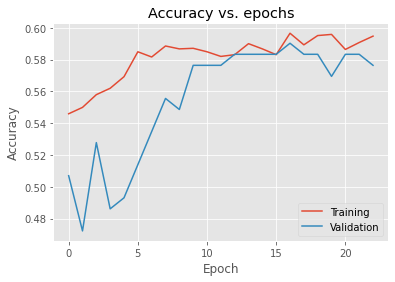

In [187]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

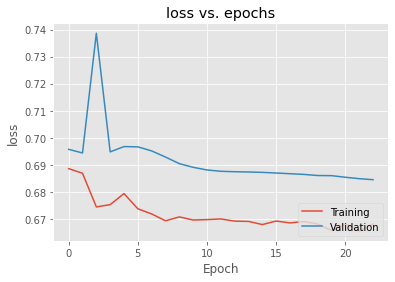

In [188]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()